# 리뷰 데이터를 통해 제품 성공 예측하기 

_**매출이 "Hit"임계치를 초과할지를 예측하기 위해 XGBoost 이용하기   [(원본)](https://github.com/jihys/sagemaker-workshop-0809/blob/master/module2-video-game-sales-xgboost.ipynb)**_

---

## 목차

1. [배경](#배경)
1. [설정](#설정)
1. [데이터](#데이터)
1. [훈련](#훈련)
1. [호스트](#호스트)
1. [평가](#평가)
1. [확장](#확장)
1. [정리](#정리)


## 배경

사용자 리뷰, 비평 리뷰, 소셜 미디어 댓글 등의 입소문은 종종 제품이 궁극적으로 성공할것인지에 대한 인사이트를 제공할 수 있습니다. 특히 비디오 게임 업계에서는 리뷰와 평가가 게임의 성공에 큰 영향을 줄 수 있습니다. 그러나 나쁜 리뷰의 게임이 모두 실패하는 것이 아니고 또한 좋은 리뷰의 게임이 hit가 되는 것 또한 아닙니다. hit게임을 예측하기 위해서는 기계학습 알고리즘은 리뷰와 함께 잠재적인 다양한 관련 데이터의 특성을 이용할 수 있습니다. 

이 노트북에서는 Kaggle의 [Video Game Sales with Ratings](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings) 데이터셋을 사용할 것입니다. 이 데이터셋은 [Metacritic](http://www.metacritic.com/browse/games/release-date/available)와 user review, 뿐만 아니라 critic review와 ESRB ratings과 다른 것들을 포함하고 있습니다. user review와 critic review는 rating score 형식으로서 0에서 10, 또는 0에서 100까지 척도로 되어있습니다. 이것들은 편리하지만 데이터셋의 중대한 문제는 상대적으로 작다는 것입니다.

이와 같이 작은 데이터셋을 다루는 것은 기계학습에서 공통적인 문제입니다. 이 문제는 종종 작은 데이터셋의 클래스간의 불균형으로 인해 악화되기도 합니다. 이러한 상황해서 앙상블 학습을 사용하는 것은 좋은 선택입니다. 이 노트북에서는 앙상블 Learner인 XGBoost를 사용하여, 게임의 hit 여부를 판단하기 위한 분류기를 만드는데 초점을 맞출 것입니다. 


## 설정

다음 설정부터 시작합니다. 

- 실습을 위해 필요한 다양한 Python 라이브러리들을 import 합니다 
- 노트북 내의 다양한 작업을 위해 SageMaker의 세션객체를 생성하고 AWS 리전 정보를 가져옵니다. 
- 학습과 모델 데이터 사용을 위한 S3 버킷과 Prefix를 설정합니다. 
- S3 데이터 접근을 위한 정의한 IAM role을 SageMaker 노트북 인스턴스에서 가져옵니다. 


In [16]:
import timeit
start_time = timeit.default_timer()

In [17]:
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt   
from IPython.display import Image                 
from IPython.display import display               
from sklearn.datasets import dump_svmlight_file   
from time import gmtime, strftime                 
import sys                                        
import math                                       
import json
import boto3
import sagemaker

session = sagemaker.Session()
region = session.boto_region_name

bucket = session.default_bucket()
prefix = 'sagemaker/videogames-xgboost'
role = sagemaker.get_execution_role()

print('Bucket: {}'.format(bucket))
print('role: {}'.format(role))

Bucket: sagemaker-ap-northeast-2-029498593638
role: arn:aws:iam::029498593638:role/service-role/AmazonSageMaker-ExecutionRole-20190920T225690


---
## 데이터

먼저 public S3 버킷에서 이 노트북 인스턴스로 데이터셋을 다운로드합니다. 이 데이터는 이 노트북과 같은 디렉토리에 나타날 것입니다. 
우리는 그 데이터를 먼저 먼저 살펴보겠습니다. 

In [18]:
# raw_data_filename = 'Video_Games_Sales_as_at_22_Dec_2016.csv'
# data_bucket = 'sagemaker-workshop-pdx'

s3 = boto3.resource('s3')
# s3.Bucket(data_bucket).download_file(raw_data_filename, 'raw_data.csv')

data = pd.read_csv('./raw_data.csv')
pd.set_option('display.max_rows', 20) 
data

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


계속 진행하기 전에, 예측할 타켓을 지정해야 합니다. 비디오게임개발 에산은 수천만달러에 이르기 때문에, 비용을 회수하고 수익을 얻기위해  게임 퍼블리셔가 "hit"게임을 퍼블리싱하는 것은 매우 중요합니다. "hit"게임은 글로벌 매출이 100만 이상인 것을 타켓으로 지정할 것입니다. 

In [20]:
data['y'] = (data['Global_Sales'] > 1)

이제 목표가 정의되었으므로  "hit"와 "not a hit" 클래스의 불균형을 살펴보도록 하겠습니다.: 

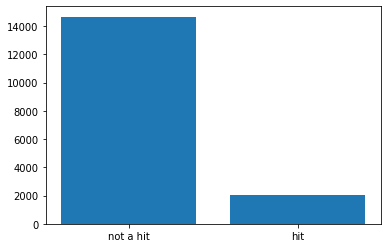

In [21]:
plt.bar(['not a hit', 'hit'], data['y'].value_counts())
plt.show()

놀라울 것도 없이, 단지 일부의 게임만이 "hits"로 간주되어집니다. 다음으로 타켓에 예측력이 높은 피처를 선택할 것입니다. 리뷰 스코어들과 글로벌 매출을 플로팅을 시작하여 이러한 스코어들이 매출에 영향을 미치는지 확인합니다. 명확성을 위해 로그스케일을 사용합니다. 

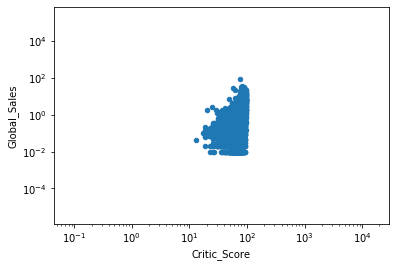

In [22]:
viz = data.filter(['User_Score','Critic_Score', 'Global_Sales'], axis=1)
viz['User_Score'] = pd.Series(viz['User_Score'].apply(pd.to_numeric, errors='coerce'))
#viz['User_Score'] = viz['User_Score'].mask(np.isnan(viz["User_Score"]), viz['Critic_Score'] / 10.0)
viz.plot(kind='scatter', logx=True, logy=True, x='Critic_Score', y='Global_Sales')
#viz.plot(kind='scatter', logx=True, logy=True, x='User_Score', y='Global_Sales')
plt.show()

리뷰 스코어들과 매출 사이의 관계에 대한 우리의 직관이 타당해보입니다. 우리는 또한 데이터셋으로부터 다른 관련 피처들을 추출할 수 있습니다. 예를 들면, ESRB raing은 'E'가 있는 게임이 일반적으로 성인 등급에 대한 연령 제한이 있는 "M"게임보다 더 넓은 사용자에 도달하기 때문에 영향이 더 미치지만, 다른 피처들, 장르 (shooter혹은 action)에 따라 M-rating 게임들 또한 큰 히트를 칠 수 있습니다. 모델은 이러한 관계들과 다른 것들을 배우게 될 것입니다.  

다음으로, 데이터셋의 피처들을 살펴보면 제외해야 할 몇개의 컬럼을 식별할 수 있습니다. 예를 들면 매출 숫자를 지정하는 5개의 컬럼이 있습니다: 이 숫자는 우리가 예측할 타켓과 직접적으로 연관이 있기 때문에 삭제해야 합니다. 게임 이름과 같은 다른 피처들도 관련이 없을 수 있습니다. 

In [23]:
data = data.drop(['Name', 'Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Count', 'User_Count', 'Developer'], axis=1)

컬럼 숫자를 줄였으니 이제 얼마나 많은 컬럼에 데이터가 누락되었는지 체크해 보겠습니다:

In [24]:
data.isnull().sum()

Platform           0
Genre              2
Publisher         54
Critic_Score    8582
User_Score      6704
Rating          6769
y                  0
dtype: int64

이 데이터셋의 Kaggle의 개요에서 언급한 것과 같이, 많은 리뷰 rating이 누락되어 있습니다. 불행하게도 그것들은 우리가 예측의 위해 의존하는 중요한 피처들이고 그들을 대체하기 위한 방법이 없기 때문에 해당 피처가 누락된 행은 삭제할 필요가 있습니다. 

In [25]:
data = data.dropna()

이제 User_Score 컬럼에 있는 문제를 해결할 것입니다: 그것은 'tbd'라는 문자열을 포함하고 있기 때문에 명백히 숫자라고 할 수 없습니다. User_Score는 범주형 피처보다는 숫자타입이 더 적합하기 때문에  문자열 타입을 숫자형으로 변환할 필요가 있고 일시적으로 tbd값들을 NaN으로 채울 것입니다. 그 다음으로  새로운 NaN 값들을 어떻게 해야할지 결정해야만 합니다. 우리는 이미 많은 행들을 버렸기 때문에 이 행들을 복구해야 합니다. 첫번째 근사치로서 Critic_Score 컬럼을 이용할 것이며, User Score는 Critic Score를 따라가는 경향이 있기 때문에  Critic Score를 10으로 나눈 값을 사용할 것입니다. 


In [26]:
data['User_Score'] = data['User_Score'].apply(pd.to_numeric, errors='coerce')
data['User_Score'] = data['User_Score'].mask(np.isnan(data["User_Score"]), data['Critic_Score'] / 10.0)

최종 데이터 전처리로서 범주형 피처들을 one-hot encdoing 메서드를 사용하여 숫자로 변환하는 것을 포함합니다.

In [27]:
if data['y'].dtype == bool:
    data['y'] = data['y'].apply(lambda y: 'yes' if y == True else 'no')
model_data = pd.get_dummies(data)

model_data.head()

,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,Platform_PS2,...,Publisher_inXile Entertainment,Rating_AO,Rating_E,Rating_E10+,Rating_K-A,Rating_M,Rating_RP,Rating_T,y_no,y_yes
0,76.0,8.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,82.0,8.3,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,80.0,8.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
6,89.0,8.5,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
7,58.0,6.6,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


모델의 오퍼피팅을 막기 위해 데이터를 3개의 그룹으로 랜덤하게 나눌 것입니다. 구체적으로 이 모델은 데이터의 70%에 대해 학습할 것입니다. 그 다음 데이터의 20%에 대해 평가하여 새로운 데이터의 정확도를 추정합니다. 최종 테스트 데이터셋으로서 나머지 10%를 남겨둘 것입니다. 

In [12]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   

Amazon SageMaker의 XGBoost는 CSV와 libSVM의 입력 데이터를 지원합니다. 우리는 여기서 피쳐와 타켓 변수를 별도의 파라미터로 제공하는 libSVM을 사용할 것입니다. 무작위 순서변경으로 인한 오정렬 문제를 피하기 위해서 위의 셀에서 분리가 완료 후 수행합니다. 학습 전에 마지막 단계로, Amazon SageMaker에서의 학습을 위한 입력으로서, 결과 파일들을 S3에 복사할 것입니다. 

In [13]:
dump_svmlight_file(X=train_data.drop(['y_no', 'y_yes'], axis=1), y=train_data['y_yes'], f='train.libsvm')
dump_svmlight_file(X=validation_data.drop(['y_no', 'y_yes'], axis=1), y=validation_data['y_yes'], f='validation.libsvm')
dump_svmlight_file(X=test_data.drop(['y_no', 'y_yes'], axis=1), y=test_data['y_yes'], f='test.libsvm')

s3.Bucket(bucket).Object(prefix + '/train/train.libsvm').upload_file('train.libsvm')
s3.Bucket(bucket).Object(prefix + '/validation/validation.libsvm').upload_file('validation.libsvm')

s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='libsvm')
s3_input_validation = sagemaker.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='libsvm')


---
## 훈련

우리의 데이터는 XGBoost 모델을 학습하기 위한 준비가 되었습니다. XGBoost 알고리즘은 많은 튜닝 가능한 하이퍼파라미터를 가지고 있습니다. 이러한 하이퍼파라미터의 일부는 다음과 같습니다. 처음에는 몇 가지만 사용하도록 할 것입니다. 

- `max_depth`: 트리의 최대 깊이. 주의사항으로, 이 값이 너무 작으면 데이터가 언더피트의 가능성이 있고, 반면 증가하면 모델이 더욱 복잡해지고 오버피트의 가능성이 있습니다.(즉, 고전적인 Bias-Variance의 트레이드오프)
- `eta`: 오버피트 방지를 위한 업데이트에서 사용되는 단계 크기 축소  
- `eval_metric`: 검증 데이터에 대한 평가 메트릭. 불균형이 있는 이와 같은 데이터는 데이터의 경우는 AUC 매트릭을 사용합니다. 
- `scale_pos_weight`: 양과 음의 가중치의 균형을 제어하여 불균형한 클래스를 갖는 데이터셋에 유용합니다.

먼저 우리는 Amazon SageMaker Estimator 객체를 위한 파라미터를 와 알고리즘 자체의 하이퍼파라미터를 설정할 것입니다. Amazon SageMaker Python SDK의 Estimator 객체는 최소한의 코드로 Training job을 설정할 수 있는 편리한 방법입니다. 

In [14]:
job_name = 'videogames-xgboost-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

from sagemaker.amazon.amazon_estimator import image_uris

container = image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='1.0-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name=job_name,
                                    instance_count=1, 
                                    instance_type='ml.c5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=session)

xgb.set_hyperparameters(max_depth=3,
                        eta=0.1,
                        subsample=0.5,
                        eval_metric='auc',
                        objective='binary:logistic',
                        scale_pos_weight=2.0,
                        num_round=100)


Training job videogames-xgboost-2021-03-02-06-07-42


다음으로, 우리는 Trainig job을 실행할 것입니다. Training job을 위한 하드웨어는 노트북 인스턴스와 별개이며 Amazon SageMaker에서 관리합니다. Amazon SageMaker는 훈련 Cluster를 설정 및 작업 완료 시에 해제하는 것과 같은 무거운 작업을 수행합니다. 다음 한줄의 코드로 Training job이 시작됩니다. 

In [15]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-03-02 06:07:45 Starting - Starting the training job...
2021-03-02 06:07:49 Starting - Launching requested ML instancesProfilerReport-1614665265: InProgress
......
2021-03-02 06:09:02 Starting - Preparing the instances for training......
2021-03-02 06:10:06 Downloading - Downloading input data...
2021-03-02 06:10:43 Training - Training image download completed. Training in progress.
2021-03-02 06:10:43 Uploading - Uploading generated training modelINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
[06:10:35] 5614x331 matrix with 33684 entries loaded from /opt/

In [17]:
s3_input_train.config

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
   'S3Uri': 's3://sagemaker-ap-northeast-2-227927015541/sagemaker/videogames-xgboost/train',
   'S3DataDistributionType': 'FullyReplicated'}},
 'ContentType': 'libsvm'}

---
## 호스트

이제 우리의 데이터로 XGBoost 알고리즘으로 훈련이 되었으므로, 훈련된 모델을 Amazon SageMaker에서 호스팅된 endpoint에 다음과 같은 간단한 코드 한줄로 배포가 가능합니다.  

In [18]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge',wait=False)

---

## 평가

이제 우리가 호스팅하는 endpoint가 있으므로, 우리는 이것으로 예측을 생성할 수 있습니다. 보다 구체적으로, 우리의 모델이 아직 보지 못한 데이터를 얼마나 잘 생성하는지 이해하기 위해서 테스트 데이터셋에서 예측을 생성해 보기로 하겠습니다. 

기계학습 모델의 성ㅇ능 비교하기 위한 많은 방법이 있습니다. 우리는 간단히 게임이 "hit" (`1`) 이거나 혹은 아니인지(`0`)에 대한 실제와 예측 값을 비교할 것입니다. 그 다음 혼동 행렬을 만들어서 모델이 각 범주에서 얼마나 많은 테스트 데이터의 포인트 수를 예측했는지와 얼마나 많은 테스트 데이터의 포인트가 실제 각 범주에 속했는지를 볼 것입니다. 

- 실시간 추론을 위해서 앞단계에서 생성한 실시간 호스팅 endpoint를 가져온다.
- Sagemaker 콘솔 네비게이션 바에서 엔드포인트를 클릭한 후 엔드포인트 이름을 COPY

In [19]:
from sagemaker.predictor import RealTimePredictor

In [20]:
xgb_predictor = RealTimePredictor(endpoint_name = '<COPY된 ENDPOINT NAME>', sagemaker_session=session, content_type = 'libsvm')

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


ClientError: An error occurred (ValidationException) when calling the DescribeEndpoint operation: 1 validation error detected: Value '<COPY된 ENDPOINT NAME>' at 'endpointName' failed to satisfy constraint: Member must satisfy regular expression pattern: ^[a-zA-Z0-9](-*[a-zA-Z0-9]){0,62}

In [ ]:
def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload, initial_args={'ContentType': 'text/x-libsvm'}).decode('utf-8')
    result = response.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]

    return preds

def batch_predict(data, batch_size):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)

In [ ]:
%%time
import json

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100)

print ('\nerror rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

In [ ]:
pd.crosstab(index=np.array(labels), columns=np.array(preds))

우리의 매트릭에 의해 테스트셋에서 "hits"인 것은 132개의 게임이었고, 모델은 정확히 70개가 넘게 식별했습니다. 반면 대략적인 에러율은 13%입니다. False Negative와 True Positive의 양은 하이퍼파라미터의 scale_pos_weight 값을 증가시킴으로서 True Positive로 유리하게 이동될 수 있습니다. 물론 이러한 증가는 정확도 감소와 에러율 증가, 그리고 추가적인 False Positive를 초래할 수 있습니다. 이러한 trade-off를 궁극적으로 어떻게 할것인가는 False Positive와 False Negative 등의 상대적 비용에 기반한 비즈니스상의 결정입니다.  

---
## 확장

이 XGBoost 모델은 게임이 리뷰와 다른 특성을 기반으로 하여 hit가 될지 여부를 에측하기 위한 출발점일 뿐입니다. 모델 성능을 향상하기위한 몇개의 가능한 방법이 있습니다. 첫째로, 우선 더 많은 데이터를 모아야 하고 가능하면 기존 누락 필드를 실제 정보로 채워야만 합니다. 또다른 가능성은 Amazon SageMaker의 Automatic Model Tuning기능을 이용한 추가적인 하이퍼파라미터 튜닝입니다. 이 기능의 예제는 [hyperparameter tuning directory of the SageMaker Examples GitHub repository](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/hyperparameter_tuning) 와 Amazon SageMaker 노트북 인스턴스의 **SageMaker Examples** 탭에서 찾을 수 있습니다. 또한 앙상블 학습은 종종 불균형 데이터셋을 잘 처리하지만 다운샘플링이나 합성 데이터증강이나 다른 접근법과 같은, 불균형을 완화할 수 있는 기술을 살펴볼 가치가 있을 수 있습니다. 
.  

---
## 정리

이 노트북이 끝나면 아래 셀을 실행시켜 주세요. 이것은 생성했던 endpoint를 제거하여 남겨진 유휴인스턴스에 요금이 발생되지 않도록 하기 위합니다.


In [ ]:
session.delete_endpoint(xgb_predictor.endpoint)